# Семинар 13 - Ранжирование на деревянных моделях

In [1]:
import math
from typing import List

import torch
import numpy as np
import pandas as pd

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from catboost.datasets import msrank_10k
from sklearn.preprocessing import StandardScaler

from utils import dcg, ndcg

seed = 42
np.random.seed(seed)

# ListNet


Вспомним реализацию ListNet из прошлого семинара. Перенесем саму модель и инициализации ее весов.

In [2]:
class ListNet(torch.nn.Module):
    def __init__(self, num_input_features: int, hidden_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.model = torch.nn.Sequential(
            torch.nn.Linear(num_input_features, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, 1),
        )

    def forward(self, input_1: torch.Tensor) -> torch.Tensor:
        logits = self.model(input_1)

        return logits
    
    
def init_weights(module):
    if isinstance(module, torch.nn.Embedding):
        module.weight.data.normal_(mean=0.0, std=1.0)
        if module.padding_idx is not None:
            module.weight.data[module.padding_idx].zero_()
    elif isinstance(module, torch.nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)
        
        
def create_model(listnet_num_input_features: int, listnet_hidden_dim: int) -> torch.nn.Module:
    torch.manual_seed(0)
    net = ListNet(listnet_num_input_features, listnet_hidden_dim)
    init_weights(net)

    return net

## Подготовка данных

Обчение модели рандирования проведем на уменьшенной версии набора данных Microsoft Learning to Rank. Этот набор данных является уменьшенной версией набора данных msrank.

Набор обучающих данных содержит 10000 объектов. Каждый объект описывается 138 колонками. Первый столбец содержит значение метки, второй — идентификатор группы объекта (GroupId). Все остальные столбцы содержат характеристики объектов.

Валидационный набор данных содержит 10000 объектов. Структура идентична обучающему набору данных.

Данные загрузим из ```catboost```.

In [3]:
def get_data() -> List[np.ndarray]:
    train_df, test_df = msrank_10k()

    X_train = train_df.drop([0, 1], axis=1).values
    y_train = train_df[0].values
    query_ids_train = train_df[1].values.astype(int)

    X_test = test_df.drop([0, 1], axis=1).values
    y_test = test_df[0].values
    query_ids_test = test_df[1].values.astype(int)

    return [X_train, y_train, query_ids_train, X_test, y_test, query_ids_test]

In [4]:
X_train, y_train, query_ids_train, X_test, y_test, query_ids_test = get_data()

In [5]:
X_train.shape, query_ids_train.shape

((10000, 136), (10000,))

In [6]:
np.unique(query_ids_train)

array([   1,   16,   31,   46,   61,   76,   91,  106,  121,  136,  151,
        166,  181,  196,  211,  226,  241,  256,  271,  286,  301,  316,
        331,  346,  361,  376,  391,  406,  421,  436,  451,  466,  481,
        496,  511,  526,  541,  556,  571,  586,  601,  616,  631,  646,
        661,  676,  691,  706,  721,  736,  751,  766,  781,  796,  811,
        826,  841,  856,  871,  886,  901,  916,  931,  946,  961,  976,
        991, 1006, 1021, 1036, 1051, 1066, 1081, 1096, 1111, 1126, 1141,
       1156, 1171, 1186, 1201, 1216, 1231, 1246, 1261, 1276, 1291])

In [7]:
X_train.mean(), X_train.std()

(2431.651767538033, 871005.5385048426)

Проведем подготовку данных для обучения. Видно, что среднее и дисперсия в данных не идеальна. Исправим это для более устойчивого обучения модели. 

Затем подготовим данные для примения в обучении модели на ```torch```.

In [8]:
def scale_features_in_query_groups(inp_feat_array: np.ndarray, inp_query_ids: np.ndarray) -> np.ndarray:
    # your code here
    # scale each data by query
    for id in np.unique(inp_query_ids):
        scaler = StandardScaler()
        idxs = inp_query_ids == id
        inp_feat_array[idxs] = scaler.fit_transform(inp_feat_array[idxs])

    return inp_feat_array


def prepare_data() -> List[np.ndarray]:
    X_train, y_train, query_ids_train, X_test, y_test, query_ids_test = get_data()
    # your code here: 
    # 1. scale train and test data 
    # 2. convert data to torch
    X_train = torch.FloatTensor(scale_features_in_query_groups(X_train, query_ids_train))
    ys_train = torch.FloatTensor(y_train)

    X_test = torch.FloatTensor(scale_features_in_query_groups(X_test, query_ids_test))
    ys_test = torch.FloatTensor(y_test)
    
    return X_train, ys_train, query_ids_train, X_test, ys_test, query_ids_test

In [9]:
X_train, ys_train, query_ids_train, X_test, ys_test, query_ids_test = prepare_data()

## Подготовка этапов обучения

In [10]:
def ndcg_k(ys_true: torch.Tensor, ys_pred: torch.Tensor, ndcg_top_k: int) -> float:
    try:
        return ndcg(ys_true, ys_pred, gain_scheme='exp2', top_k=ndcg_top_k)
    except ZeroDivisionError:
        return float(0)

In [11]:
def calc_loss(batch_ys: torch.FloatTensor, batch_pred: torch.FloatTensor) -> torch.FloatTensor:
    P_y_i = torch.softmax(batch_ys, dim=0)
    P_z_i = torch.softmax(batch_pred, dim=0)

    return -torch.sum(P_y_i * torch.log(P_z_i))

In [12]:
n_epochs: int = 5
listnet_hidden_dim: int = 30
lr: float = 0.001
ndcg_top_k: int = 10
num_input_features = X_train.shape[1]


model = create_model(num_input_features, listnet_hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [13]:
def _train_one_epoch(model, optimizer, X_train, ys_train, query_ids_train) -> None:
    # your code here
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    for id in np.unique(query_ids_train):
        idxs = query_ids_train == id
        x = X_train[idxs]
        ys = ys_train[idxs]

        with torch.enable_grad():
            pred = model(x)
            loss = calc_loss(ys.squeeze(), pred.squeeze())
            loss.backward(retain_graph=True)
            optimizer.step()

        optimizer.zero_grad()
        model.zero_grad()

In [14]:
_train_one_epoch(model, optimizer, X_train, ys_train, query_ids_train)

In [15]:
def _eval_test_set(model, X_test, ys_test, query_ids_test) -> float:
    # your code here
    with torch.no_grad():
        model.eval()
        ndcgs = []

        for id in np.unique(query_ids_test):
            idxs = query_ids_test == id
            x = X_test[idxs]
            ys = ys_test[idxs]
            pred = model(x)

            score = ndcg_k(ys.squeeze(), pred.squeeze(), ndcg_top_k)
            ndcgs.append(score)

    return np.mean(ndcgs)

In [16]:
_eval_test_set(model, X_test, ys_test, query_ids_test)

0.4258056561587274

In [17]:
def fit(n_epochs, model, optimizer, X_train, ys_train, query_ids_train, X_test, ys_test, query_ids_test) -> List[float]:
    val_ndcg = []
    
    for epoch in tqdm(range(n_epochs)):
        _train_one_epoch(model, optimizer, X_train, ys_train, query_ids_train)
        val_metric = _eval_test_set(model, X_test, ys_test, query_ids_test)

        val_ndcg.append(val_metric)

    return val_ndcg

In [18]:
n_epochs: int = 100
listnet_hidden_dim: int = 10
lr: float = 0.001
ndcg_top_k: int = 10
num_input_features = X_train.shape[1]


model = create_model(num_input_features, listnet_hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


val_ndcg = fit(n_epochs, model, optimizer, X_train, ys_train, query_ids_train, X_test, ys_test, query_ids_test)

  0%|          | 0/100 [00:00<?, ?it/s]

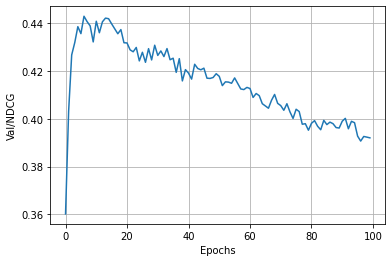

In [19]:
plt.plot(val_ndcg)
plt.xlabel('Epochs')
plt.ylabel('Val/NDCG')
plt.grid()
plt.show()

# LambdaRank

$$\lambda = \left(0.5 * (1 - S_{ij}) - \frac {1} {1 + e^{s_i - s_j}}\right) |\Delta nDCG|$$

$$\Delta nDCG = \frac {1} {IdealDCG} (2^i - 2^j) \left(\frac {1} {log_2(1+i)} - \frac {1} {log_2(1+j)}\right)$$

In [20]:
# в y_true лежат оценки релевантности
y_true = torch.LongTensor([[5, 3, 2, 5, 1, 1]]).reshape(-1, 1)
y_pred = torch.FloatTensor([3.2, 0.4, -0.1, -2.1, 0.5, 0.01]).reshape(-1, 1)

In [21]:
y_pred

tensor([[ 3.2000],
        [ 0.4000],
        [-0.1000],
        [-2.1000],
        [ 0.5000],
        [ 0.0100]])

In [22]:
def compute_lambdas(y_true, y_pred, ndcg_scheme='exp2'):
    # рассчитаем нормировку, IdealDCG
    ideal_dcg = dcg(y_true, y_true, ndcg_scheme)
    N = 1 / ideal_dcg
    
    # рассчитаем порядок документов согласно оценкам релевантности
    _, rank_order = torch.sort(y_true, descending=True, axis=0)
    rank_order += 1
    
    with torch.no_grad():
        # получаем все попарные разницы скоров в батче
        pos_pairs_score_diff = 1.0 + torch.exp((y_pred - y_pred.t()))
        
        # поставим разметку для пар, 1 если первый документ релевантнее
        # -1 если второй документ релевантнее
        Sij = compute_labels_in_batch(y_true)
        # посчитаем изменение gain из-за перестановок
        gain_diff = compute_gain_diff(y_true, ndcg_scheme)
        
        # посчитаем изменение знаменателей-дискаунтеров
        decay_diff = (1.0 / torch.log2(rank_order + 1.0)) - (1.0 / torch.log2(rank_order.t() + 1.0))
        # посчитаем непосредственное изменение nDCG
        delta_ndcg = torch.abs(N * gain_diff * decay_diff)
        # посчитаем лямбды
        lambda_update =  (0.5 * (1 - Sij) - 1 / pos_pairs_score_diff) * delta_ndcg
        lambda_update = torch.sum(lambda_update, dim=1, keepdim=True)
        
        return Sij, gain_diff, decay_diff, delta_ndcg, lambda_update
    
    
def compute_labels_in_batch(y_true):
    
    # разница релевантностей каждого с каждым объектом
    rel_diff = y_true - y_true.t()
    
    # 1 в этой матрице - объект более релевантен
    pos_pairs = (rel_diff > 0).type(torch.float32)
    
    # 1 тут - объект менее релевантен
    neg_pairs = (rel_diff < 0).type(torch.float32)
    Sij = pos_pairs - neg_pairs
    return Sij


def compute_gain_diff(y_true, gain_scheme):
    if gain_scheme == "exp2":
        gain_diff = torch.pow(2.0, y_true) - torch.pow(2.0, y_true.t())
    elif gain_scheme == "diff":
        gain_diff = y_true - y_true.t()
    else:
        raise ValueError(f"{gain_scheme} method not supported")
    return gain_diff

In [23]:
y_pred - y_pred.t()

tensor([[ 0.0000,  2.8000,  3.3000,  5.3000,  2.7000,  3.1900],
        [-2.8000,  0.0000,  0.5000,  2.5000, -0.1000,  0.3900],
        [-3.3000, -0.5000,  0.0000,  2.0000, -0.6000, -0.1100],
        [-5.3000, -2.5000, -2.0000,  0.0000, -2.6000, -2.1100],
        [-2.7000,  0.1000,  0.6000,  2.6000,  0.0000,  0.4900],
        [-3.1900, -0.3900,  0.1100,  2.1100, -0.4900,  0.0000]])

In [24]:
y_true - y_true.t()

tensor([[ 0,  2,  3,  0,  4,  4],
        [-2,  0,  1, -2,  2,  2],
        [-3, -1,  0, -3,  1,  1],
        [ 0,  2,  3,  0,  4,  4],
        [-4, -2, -1, -4,  0,  0],
        [-4, -2, -1, -4,  0,  0]])

In [25]:
Sij, gain_diff, decay_diff, delta_ndcg, lambda_update = compute_lambdas(y_true, y_pred)

In [26]:
Sij

tensor([[ 0.,  1.,  1.,  0.,  1.,  1.],
        [-1.,  0.,  1., -1.,  1.,  1.],
        [-1., -1.,  0., -1.,  1.,  1.],
        [ 0.,  1.,  1.,  0.,  1.,  1.],
        [-1., -1., -1., -1.,  0.,  0.],
        [-1., -1., -1., -1.,  0.,  0.]])

In [27]:
gain_diff

tensor([[  0.,  24.,  28.,   0.,  30.,  30.],
        [-24.,   0.,   4., -24.,   6.,   6.],
        [-28.,  -4.,   0., -28.,   2.,   2.],
        [  0.,  24.,  28.,   0.,  30.,  30.],
        [-30.,  -6.,  -2., -30.,   0.,   0.],
        [-30.,  -6.,  -2., -30.,   0.,   0.]])

In [28]:
# пример вычисления элемента gain diff для первого (релевантность 5) и последнего документа (1); 
# для первого (5) и второго (3) документа
(2**5 - 1) - (2**1 -1), (2**5 - 1) - (2**3-1)

(30, 24)

In [29]:
decay_diff

tensor([[ 0.0000,  0.5693,  0.3691,  0.5000,  0.6131,  0.6438],
        [-0.5693,  0.0000, -0.2003, -0.0693,  0.0438,  0.0745],
        [-0.3691,  0.2003,  0.0000,  0.1309,  0.2441,  0.2747],
        [-0.5000,  0.0693, -0.1309,  0.0000,  0.1131,  0.1438],
        [-0.6131, -0.0438, -0.2441, -0.1131,  0.0000,  0.0306],
        [-0.6438, -0.0745, -0.2747, -0.1438, -0.0306,  0.0000]])

In [30]:
# посчитаем изменение знаменателей-дискаунтеров для первого и последнего документа
(1 / np.log2(1+1)) - (1 / np.log2(1+6))

0.6437928128919779

In [31]:
delta_ndcg

tensor([[0.0000, 0.2436, 0.1842, 0.0000, 0.3279, 0.3443],
        [0.2436, 0.0000, 0.0143, 0.0297, 0.0047, 0.0080],
        [0.1842, 0.0143, 0.0000, 0.0654, 0.0087, 0.0098],
        [0.0000, 0.0297, 0.0654, 0.0000, 0.0605, 0.0769],
        [0.3279, 0.0047, 0.0087, 0.0605, 0.0000, 0.0000],
        [0.3443, 0.0080, 0.0098, 0.0769, 0.0000, 0.0000]])

In [32]:
lambda_update

tensor([[-0.0548],
        [ 0.0303],
        [ 0.0587],
        [-0.2099],
        [ 0.0851],
        [ 0.0906]])

In [33]:
for _ in range(100):
    _, _, _, _, lambda_update = compute_lambdas(y_true, y_pred)
    y_pred -= lambda_update

In [34]:
rank_indexes = torch.argsort(y_pred, dim=0, descending=True)

In [35]:
y_pred

tensor([[ 4.3905],
        [-0.1219],
        [-1.0463],
        [ 2.0759],
        [-1.5135],
        [-1.8746]])

In [36]:
y_true[rank_indexes]

tensor([[[5]],

        [[5]],

        [[3]],

        [[2]],

        [[1]],

        [[1]]])

In [37]:
# полностью правильное ранжирование
torch.sort(y_true, dim=0, descending=True)[0]

tensor([[5],
        [5],
        [3],
        [2],
        [1],
        [1]])

In [38]:
y_true = torch.LongTensor([[5,3,2,5,1,1]]).reshape(-1,1)

# совсем плохие предсказанные скоры в начале
y_pred = torch.FloatTensor([-3.0, 2.0, 3.0, -4.0, 6.0, 8.5]).reshape(-1,1)

In [39]:
ndcg(y_true, y_pred)

0.5202084224304782

In [40]:
for _ in range(100):
    _, _, _, _, lambda_update = compute_lambdas(y_true, y_pred)
    y_pred -= lambda_update

In [41]:
ndcg(y_true, y_pred)

1.0

In [42]:
# полностью правильное ранжирование при увеличении количества итераций
y_pred

tensor([[6.2690],
        [1.2374],
        [0.5772],
        [3.6842],
        [0.3482],
        [0.3840]])